# Setup for Vars

In [1]:
import numpy as np

In [2]:
import os
HOME = os.getcwd()
print(HOME)


/teamspace/studios/this_studio/COGS181-YOLOProject


In [3]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))


/teamspace/studios/this_studio/COGS181-YOLOProject/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [4]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))


/teamspace/studios/this_studio/COGS181-YOLOProject/weights/groundingdino_swint_ogc.pth ; exist: True


In [5]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/teamspace/studios/this_studio/COGS181-YOLOProject/GroundingDINO


final text_encoder_type: bert-base-uncased


# Trial on Cat DB

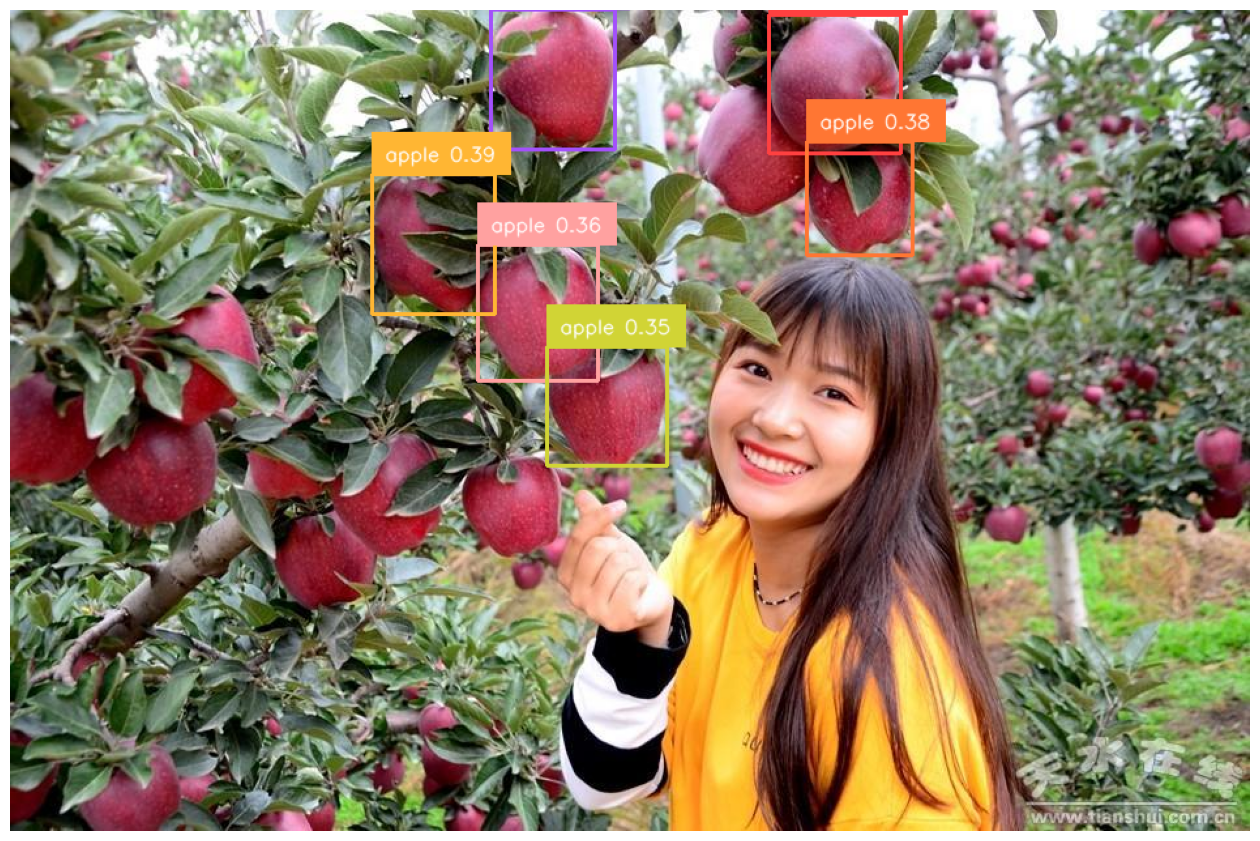

In [8]:
import os
import supervision as sv

IMAGE_NAME = "00002.jpg"
IMAGE_PATH = os.path.join(HOME, "apl/JPEGImages", IMAGE_NAME)

TEXT_PROMPT = "apple"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline  
sv.plot_image(annotated_frame, (16, 16))


# Trying YOLO on the same

In [28]:
!pip install ultralytics

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 98.8 MB/s eta 0:00:00


In [29]:
import os
import cv2
import torch
import supervision as sv
import matplotlib.pyplot as plt
from ultralytics import YOLO  # YOLOv8 supports YOLO-World


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/teamspace/studios/this_studio/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [34]:
!wget https://github.com/Ultralytics/YOLO-World/releases/download/v1.0/yolo_world.pt -P HOME

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2025-03-16 09:44:03--  https://github.com/Ultralytics/YOLO-World/releases/download/v1.0/yolo_world.pt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-03-16 09:44:03 ERROR 404: Not Found.



In [ ]:
MODEL_PATH = os.path.join(HOME, "yolo_world.pt")  # Adjust model path
model = YOLO(MODEL_PATH)

# Load the image
image_source = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# Run YOLO-World on the image
results = model(image_rgb)

# Extract bounding boxes, confidences, and class labels
boxes = results[0].boxes.xyxy.cpu().numpy()  # (x_min, y_min, x_max, y_max)
confidences = results[0].boxes.conf.cpu().numpy()
class_ids = results[0].boxes.cls.cpu().numpy()
labels = [model.names[int(cls)] for cls in class_ids]  # Convert class IDs to labels

# Debugging print statements
print("Predicted boxes:", boxes)
print("Labels:", labels)

# Create detections for visualization
detections = sv.Detections(xyxy=boxes, class_id=class_ids)

# Annotate the image with predictions
annotator = sv.BoxAnnotator()
annotated_image = annotator.annotate(scene=image_rgb, detections=detections, labels=labels)

# Display the annotated image
plt.figure(figsize=(16, 16))
plt.imshow(annotated_image)
plt.axis("off")
plt.title("YOLO-World Predictions")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/teamspace/studios/this_studio/COGS181-YOLOProject/weights/yolo_world.pt'

# Boundry Box Annotations

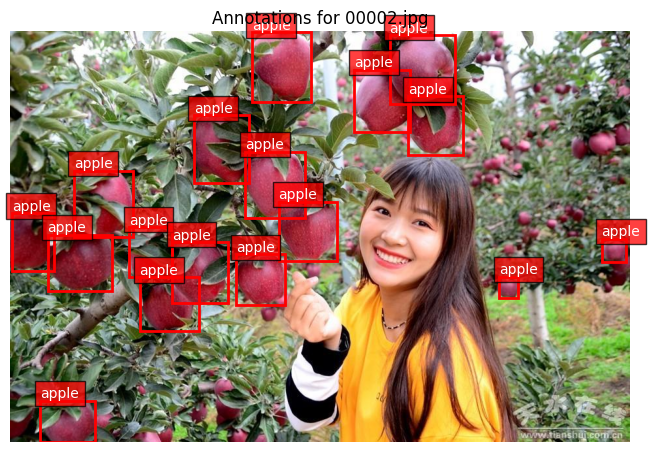

In [9]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define dataset paths
DATASET_PATH = "/teamspace/studios/this_studio/COGS181-YOLOProject/apl"
IMAGE_FOLDER = os.path.join(DATASET_PATH, "JPEGImages")
ANNOTATION_FOLDER = os.path.join(DATASET_PATH, "annotations")

# Function to parse XML annotation file
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    boxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text  # Object label
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(name)
    
    return boxes, labels

# Get a list of all annotation files
annotation_files = sorted(os.listdir(ANNOTATION_FOLDER))

# Select the first annotation file to visualize
xml_file = os.path.join(ANNOTATION_FOLDER, annotation_files[0])

# Parse the annotation
boxes, labels = parse_annotation(xml_file)

# Get the corresponding image file
image_filename = annotation_files[0].replace(".xml", ".jpg")  # Assuming JPEG format
image_path = os.path.join(IMAGE_FOLDER, image_filename)

# Load and display the image with bounding boxes
img = Image.open(image_path)
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img)

# Add bounding boxes
for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 5, label, fontsize=10, color="white", bbox=dict(facecolor="red", alpha=0.75))

ax.axis("off")
plt.title(f"Annotations for {image_filename}")
plt.show()

# IoU Calc

In [8]:
'''
# Convert predicted boxes to absolute coordinates (rescale from 0-1 to image size)
pred_boxes = []
for box in boxes:
    # Check if box is a tensor or a list/array
    if hasattr(box, 'cpu'):
        # It's a tensor
        x_min, y_min, x_max, y_max = box.cpu().numpy()
    else:
        # It's a list or numpy array
        x_min, y_min, x_max, y_max = box
    
    # Scale normalized coordinates to image dimensions
    x_min *= image_width
    x_max *= image_width
    y_min *= image_height
    y_max *= image_height
    pred_boxes.append([x_min, y_min, x_max, y_max])

pred_boxes = np.array(pred_boxes)  # Convert to NumPy array
for i, gt_box in enumerate(gt_boxes):
    print(f"GT box {i}: {gt_box}")
for i, pred_box in enumerate(pred_boxes):
    print(f"Pred box {i}: {pred_box}")
for i, box in enumerate(pred_boxes):
    if not (box[0] < box[2] and box[1] < box[3]):
        print(f"Invalid prediction box {i}: {box}")
for i, box in enumerate(gt_boxes):
    if not (box[0] < box[2] and box[1] < box[3]):
        print(f"Invalid ground truth box {i}: {box}")
# Convert predicted boxes from [x_center, y_center, width, height] to [x_min, y_min, x_max, y_max]
converted_pred_boxes = []
for box in pred_boxes:
    x_center, y_center, width, height = box
    
    # Calculate coordinates
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)
    
    converted_pred_boxes.append([x_min, y_min, x_max, y_max])

# Replace pred_boxes with the converted version
pred_boxes = np.array(converted_pred_boxes)

# Add debug print to verify the conversion
print("Converted prediction boxes:")
for i, box in enumerate(pred_boxes):
    print(f"Converted Pred box {i}: {box}")
# Function to compute IoU
def compute_iou(box1, box2):
    x1, y1, x1_max, y1_max = box1
    x2, y2, x2_max, y2_max = box2

    # Compute intersection
    x_inter = max(0, min(x1_max, x2_max) - max(x1, x2))
    y_inter = max(0, min(y1_max, y2_max) - max(y1, y2))
    intersection = x_inter * y_inter

    # Compute union
    area1 = (x1_max - x1) * (y1_max - y1)
    area2 = (x2_max - x2) * (y2_max - y2)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

# Evaluate Predictions
TP = 0  # True Positives
FP = 0  # False Positives
FN = len(gt_boxes)  # Assume all GT are FN initially
iou_scores = []

for pred_box in pred_boxes:
    best_iou = 0
    best_match = None

    for i, gt_box in enumerate(gt_boxes):
        iou = compute_iou(pred_box, gt_box)
        print(f"IoU between Prediction {pred_box} and GT {gt_box}: {iou:.2f}")  # Debug IoU
        if iou > best_iou:
            best_iou = iou
            best_match = i

    if best_iou >= 0.5 and best_match is not None:
        TP += 1  # True Positive
        FN -= 1  # Reduce False Negatives
        iou_scores.append(best_iou)
    else:
        FP += 1  # False Positive

# Compute Precision and Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
mean_iou = np.mean(iou_scores) if iou_scores else 0

# Print Evaluation Results
print("\nFinal Evaluation Results:")
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"Mean IoU: {mean_iou:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import supervision as sv
from PIL import Image
from groundingdino.util.inference import load_image, predict, annotate


# Function to compute IoU
def compute_iou(box1, box2):
    """ Compute IoU between two bounding boxes in absolute coordinates. """
    x1, y1, x1_max, y1_max = box1
    x2, y2, x2_max, y2_max = box2

    # Compute intersection
    x_inter = max(0, min(x1_max, x2_max) - max(x1, x2))
    y_inter = max(0, min(y1_max, y2_max) - max(y1, y2))
    intersection = x_inter * y_inter

    # Compute union
    area1 = (x1_max - x1) * (y1_max - y1)
    area2 = (x2_max - x2) * (y2_max - y2)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

# Evaluate Predictions
TP = 0  # True Positives
FP = 0  # False Positives
FN = len(gt_boxes)  # Assume all GT are FN initially
iou_scores = []

for pred_box in pred_boxes:
    best_iou = 0
    best_match = None

    for i, gt_box in enumerate(gt_boxes):
        iou = compute_iou(pred_box, gt_box)
        print(f"IoU between Prediction {pred_box} and GT {gt_box}: {iou:.2f}")  # Debug IoU
        if iou > best_iou:
            best_iou = iou
            best_match = i

    if best_iou >= 0.5 and best_match is not None:
        TP += 1  # True Positive
        FN -= 1  # Reduce False Negatives
        iou_scores.append(best_iou)
    else:
        FP += 1  # False Positive

# Compute Precision and Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
mean_iou = np.mean(iou_scores) if iou_scores else 0

# Print Evaluation Results
print("\nFinal Evaluation Results:")
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"Mean IoU: {mean_iou:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# ---- VISUALIZATION ----
# Annotate Grounding DINO Predictions
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# Annotate Ground Truth (COCO Annotations)
gt_detections = sv.Detections(
    xyxy=gt_boxes,  # Already in [x_min, y_min, x_max, y_max] format
    class_id=np.arange(len(gt_boxes))
)

gt_annotator = sv.BoxAnnotator(color=sv.Color.BLUE)
annotated_gt_image = gt_annotator.annotate(scene=image_source.copy(), detections=gt_detections)

# Show Side-by-Side Comparisons
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(annotated_gt_image)
axs[0].set_title("Ground Truth Annotations (Blue)")
axs[0].axis("off")

axs[1].imshow(annotated_frame)
axs[1].set_title("Grounding DINO Predictions (Red)")
axs[1].axis("off")

plt.show()
'''



'\n# Convert predicted boxes to absolute coordinates (rescale from 0-1 to image size)\npred_boxes = []\nfor box in boxes:\n    # Check if box is a tensor or a list/array\n    if hasattr(box, \'cpu\'):\n        # It\'s a tensor\n        x_min, y_min, x_max, y_max = box.cpu().numpy()\n    else:\n        # It\'s a list or numpy array\n        x_min, y_min, x_max, y_max = box\n    \n    # Scale normalized coordinates to image dimensions\n    x_min *= image_width\n    x_max *= image_width\n    y_min *= image_height\n    y_max *= image_height\n    pred_boxes.append([x_min, y_min, x_max, y_max])\n\npred_boxes = np.array(pred_boxes)  # Convert to NumPy array\nfor i, gt_box in enumerate(gt_boxes):\n    print(f"GT box {i}: {gt_box}")\nfor i, pred_box in enumerate(pred_boxes):\n    print(f"Pred box {i}: {pred_box}")\nfor i, box in enumerate(pred_boxes):\n    if not (box[0] < box[2] and box[1] < box[3]):\n        print(f"Invalid prediction box {i}: {box}")\nfor i, box in enumerate(gt_boxes):\n    

# Final Code

In [10]:
IMAGE_NAME = "00002.jpg"  # Change this for another test image
IMAGE_PATH = os.path.join(IMAGE_FOLDER, IMAGE_NAME)
ANNOTATION_FILE = os.path.join(ANNOTATION_FOLDER, IMAGE_NAME.replace(".jpg", ".xml"))

# Load image for size reference
image = Image.open(IMAGE_PATH)
image_width, image_height = image.size  # Get actual image dimensions


In [11]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    boxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text  # Object label
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])  # Format: [x_min, y_min, x_max, y_max]
        labels.append(name)
    
    return np.array(boxes), labels

# Load ground truth annotations
gt_boxes, gt_labels = parse_annotation(ANNOTATION_FILE)
print(f"Ground truth boxes: {gt_boxes}")
print(f"Image dimensions: {image_width} x {image_height}")

# Load image
image_source, image_tensor = load_image(IMAGE_PATH)


Ground truth boxes: [[346 341 421 419]
 [610  99 694 188]
 [749 375 778 408]
 [581   5 682 110]
 [411 260 500 351]
 [  2 278  67 366]
 [527  58 612 153]
 [906 317 944 353]
 [182 299 248 375]
 [360 184 452 285]
 [ 97 213 188 314]
 [ 57 311 156 397]
 [370   1 460 107]
 [248 322 333 415]
 [ 46 565 130 628]
 [198 376 289 458]
 [281 128 365 231]]
Image dimensions: 950 x 629


In [12]:
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

boxes, logits, phrases = predict(
    model=model, 
    image=image_tensor, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

# Debug information about boxes
print(f"Type of boxes: {type(boxes)}")
if len(boxes) > 0:
    print(f"Type of first box: {type(boxes[0])}")
    print(f"First box: {boxes[0]}")


Type of boxes: <class 'torch.Tensor'>
Type of first box: <class 'torch.Tensor'>
First box: tensor([0.4379, 0.0857, 0.1009, 0.1704])


In [13]:
pred_boxes = []
for box in boxes:
    # Check if box is a tensor or a list/array
    if hasattr(box, 'cpu'):
        # It's a tensor
        x_min, y_min, x_max, y_max = box.cpu().numpy()
    else:
        # It's a list or numpy array
        x_min, y_min, x_max, y_max = box

    # Scale normalized coordinates to image dimensions
    x_min *= image_width
    x_max *= image_width
    y_min *= image_height
    y_max *= image_height
    pred_boxes.append([x_min, y_min, x_max, y_max])

pred_boxes = np.array(pred_boxes)  # Convert to NumPy array
print(f"Predicted boxes (after conversion): {pred_boxes}")

Predicted boxes (after conversion): [[415.99671096  53.91053806  95.81104703 107.18809138]
 [631.9506973   57.57293873 100.22312216 105.45766069]
 [404.50280458 232.78254709  92.92556606 104.01416045]
 [650.97814202 144.83914472  80.84074147  87.12952201]
 [324.57031161 179.8169075   94.73847449 106.8149965 ]
 [457.64368325 303.94032559  91.50081091  91.78985262]]


In [14]:
converted_pred_boxes = []
for box in pred_boxes:
    x_center, y_center, width, height = box
    
    # Calculate coordinates
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)
    
    converted_pred_boxes.append([x_min, y_min, x_max, y_max])

# Replace pred_boxes with the converted version
pred_boxes = np.array(converted_pred_boxes)

# Add debug print to verify the conversion
print("Converted prediction boxes:")
for i, box in enumerate(pred_boxes):
    print(f"Converted Pred box {i}: {box}")

Converted prediction boxes:
Converted Pred box 0: [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02]
Converted Pred box 1: [581.83913622   4.84410838 682.06225839 110.30176907]
Converted Pred box 2: [358.04002155 180.77546686 450.96558761 284.78962731]
Converted Pred box 3: [610.55777129 101.27438372 691.39851276 188.40390573]
Converted Pred box 4: [277.20107436 126.40940925 371.93954885 233.22440574]
Converted Pred box 5: [411.8932778  258.04539928 503.39408871 349.8352519 ]


In [15]:
# Print actual box coordinates
print("Ground truth boxes:")
for i, gt_box in enumerate(gt_boxes):
    print(f"GT box {i}: {gt_box}")

print("Prediction boxes:")
for i, pred_box in enumerate(pred_boxes):
    print(f"Pred box {i}: {pred_box}")


Ground truth boxes:
GT box 0: [346 341 421 419]
GT box 1: [610  99 694 188]
GT box 2: [749 375 778 408]
GT box 3: [581   5 682 110]
GT box 4: [411 260 500 351]
GT box 5: [  2 278  67 366]
GT box 6: [527  58 612 153]
GT box 7: [906 317 944 353]
GT box 8: [182 299 248 375]
GT box 9: [360 184 452 285]
GT box 10: [ 97 213 188 314]
GT box 11: [ 57 311 156 397]
GT box 12: [370   1 460 107]
GT box 13: [248 322 333 415]
GT box 14: [ 46 565 130 628]
GT box 15: [198 376 289 458]
GT box 16: [281 128 365 231]
Prediction boxes:
Pred box 0: [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02]
Pred box 1: [581.83913622   4.84410838 682.06225839 110.30176907]
Pred box 2: [358.04002155 180.77546686 450.96558761 284.78962731]
Pred box 3: [610.55777129 101.27438372 691.39851276 188.40390573]
Pred box 4: [277.20107436 126.40940925 371.93954885 233.22440574]
Pred box 5: [411.8932778  258.04539928 503.39408871 349.8352519 ]


In [16]:
# Check for invalid boxes
for i, box in enumerate(pred_boxes):
    if not (box[0] < box[2] and box[1] < box[3]):
        print(f"Invalid prediction box {i}: {box}")
for i, box in enumerate(gt_boxes):
    if not (box[0] < box[2] and box[1] < box[3]):
        print(f"Invalid ground truth box {i}: {box}")


In [17]:
# Function to compute IoU
def compute_iou(box1, box2):
    """ Compute IoU between two bounding boxes in absolute coordinates. """
    x1, y1, x1_max, y1_max = box1
    x2, y2, x2_max, y2_max = box2

    # Compute intersection
    x_inter = max(0, min(x1_max, x2_max) - max(x1, x2))
    y_inter = max(0, min(y1_max, y2_max) - max(y1, y2))
    intersection = x_inter * y_inter

    # Compute union
    area1 = (x1_max - x1) * (y1_max - y1)
    area2 = (x2_max - x2) * (y2_max - y2)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

# Evaluate Predictions
TP = 0  # True Positives
FP = 0  # False Positives
FN = len(gt_boxes)  # Assume all GT are FN initially
iou_scores = []
matched_gt_indices = set()  # Track which ground truths have been matched

for pred_box in pred_boxes:
    best_iou = 0
    best_match = None

    for i, gt_box in enumerate(gt_boxes):
        iou = compute_iou(pred_box, gt_box)
        print(f"IoU between Prediction {pred_box} and GT {gt_box}: {iou:.2f}")
        if iou > best_iou:
            best_iou = iou
            best_match = i

    if best_iou >= 0.5 and best_match is not None:
        # Check if this ground truth hasn't been matched already
        if best_match not in matched_gt_indices:
            TP += 1  # True Positive
            FN -= 1  # Reduce False Negatives
            iou_scores.append(best_iou)
            matched_gt_indices.add(best_match)  # Mark this GT as matched
        else:
            FP += 1  # Duplicate detection (already matched this GT)
    else:
        FP += 1  # False Positive

# Compute Precision and Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
mean_iou = np.mean(iou_scores) if iou_scores else 0

# Print Evaluation Results
print("\nFinal Evaluation Results:")
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"Mean IoU: {mean_iou:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {2 * precision * recall / (precision + recall):.2f}" if (precision + recall) > 0 else "F1 Score: 0")



IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02] and GT [346 341 421 419]: 0.00
IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02] and GT [610  99 694 188]: 0.00
IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02] and GT [749 375 778 408]: 0.00
IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02] and GT [581   5 682 110]: 0.00
IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02] and GT [411 260 500 351]: 0.00
IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02] and GT [  2 278  67 366]: 0.00
IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02] and GT [527  58 612 153]: 0.00
IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.07504584e+02] and GT [906 317 944 353]: 0.00
IoU between Prediction [3.68091187e+02 3.16492364e-01 4.63902234e+02 1.0

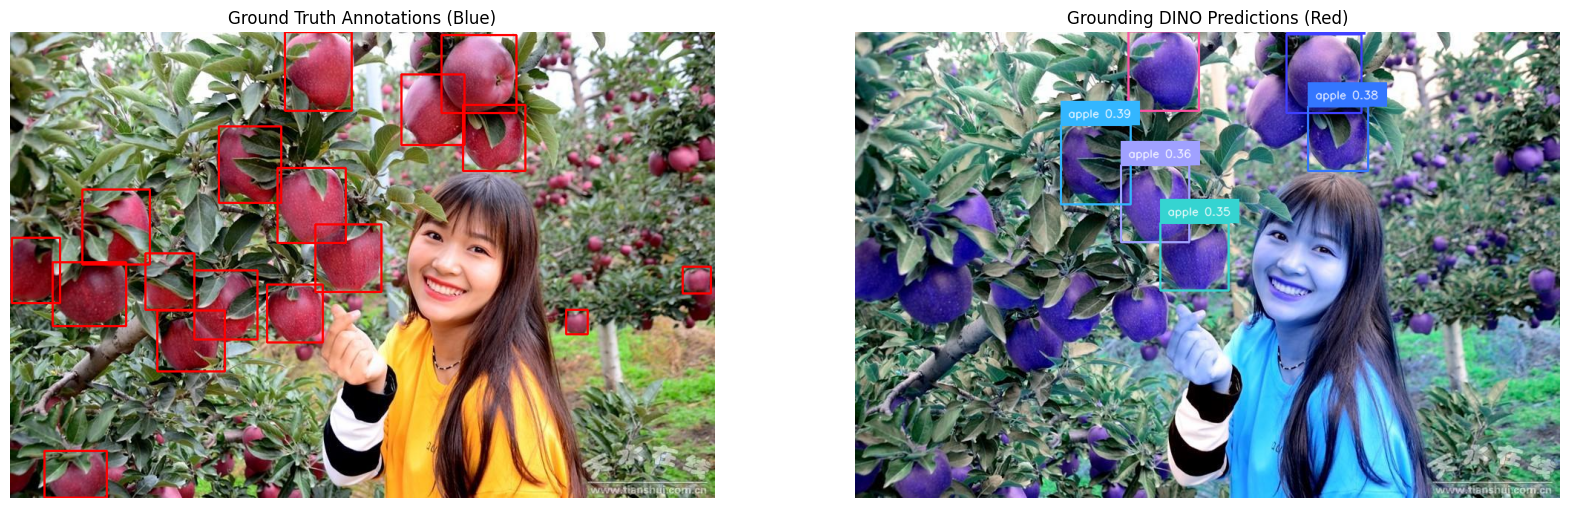

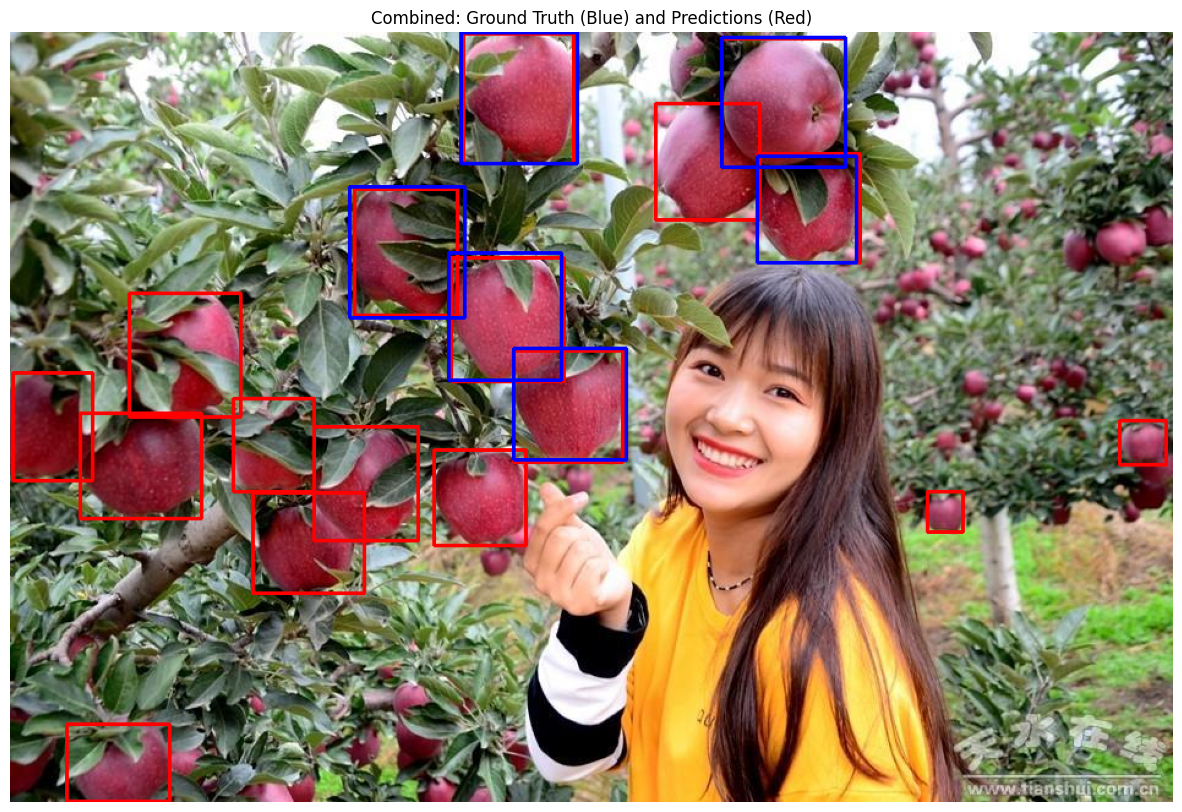

In [18]:
# Annotate Grounding DINO Predictions
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# Convert ground truth boxes to supervision format
gt_detections = sv.Detections(
    xyxy=gt_boxes,  # Already in [x_min, y_min, x_max, y_max] format
    class_id=np.arange(len(gt_boxes))
)

# Create a ground truth annotator with blue color
gt_annotator = sv.BoxAnnotator(color=sv.Color.BLUE)
annotated_gt_image = gt_annotator.annotate(scene=image_source.copy(), detections=gt_detections)

# Show both images side-by-side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(annotated_gt_image)
axs[0].set_title("Ground Truth Annotations (Blue)")
axs[0].axis("off")

axs[1].imshow(annotated_frame)
axs[1].set_title("Grounding DINO Predictions (Red)")
axs[1].axis("off")

# Create a third visualization showing both GT and predictions together
pred_detections = sv.Detections(
    xyxy=pred_boxes,
    class_id=np.arange(len(pred_boxes))
)

combined_image = image_source.copy()
gt_annotator = sv.BoxAnnotator(color=sv.Color.BLUE)
pred_annotator = sv.BoxAnnotator(color=sv.Color.RED)

# Draw ground truth boxes in blue
combined_image = gt_annotator.annotate(
    scene=combined_image, 
    detections=gt_detections,
    #labels=[f"GT-{i}" for i in range(len(gt_boxes))]
)

# Draw prediction boxes in red
combined_image = pred_annotator.annotate(
    scene=combined_image, 
    detections=pred_detections,
    #labels=[f"Pred-{i}" for i in range(len(pred_boxes))]
)

# Add a third plot for combined visualization
fig2, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(combined_image)
ax.set_title("Combined: Ground Truth (Blue) and Predictions (Red)")
ax.axis("off")

plt.show()


# Running over all imgs and getting avg IoU

In [21]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import supervision as sv
from PIL import Image


In [25]:
IMAGE_FOLDER = os.path.join(HOME, "apl/JPEGImages")
ANNOTATION_FOLDER = os.path.join(HOME, "apl/annotations")

results = []

TEXT_PROMPT = "apple"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

# Iterate over every image in JPEGImages folder
for image_name in os.listdir(IMAGE_FOLDER):
    if image_name.lower().endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(IMAGE_FOLDER, image_name)
        annotation_path = os.path.join(ANNOTATION_FOLDER, image_name.replace(".jpg", ".xml"))

        # Load image for size reference
        image = Image.open(image_path)
        image_width, image_height = image.size  

        # Load ground truth annotations
        gt_boxes, gt_labels = parse_annotation(annotation_path)

        # Load image for model prediction
        image_source, image_tensor = load_image(image_path)

        # Run GroundingDINO prediction
        boxes, logits, phrases = predict(
            model=model, 
            image=image_tensor, 
            caption=TEXT_PROMPT, 
            box_threshold=BOX_THRESHOLD, 
            text_threshold=TEXT_THRESHOLD
        )

        # Convert predicted boxes from normalized format to absolute pixel format
        pred_boxes = []
        for box in boxes:
            if hasattr(box, 'cpu'):  # If it's a tensor
                x_min, y_min, x_max, y_max = box.cpu().numpy()
            else:
                x_min, y_min, x_max, y_max = box

            x_min *= image_width
            x_max *= image_width
            y_min *= image_height
            y_max *= image_height
            pred_boxes.append([x_min, y_min, x_max, y_max])
        
        pred_boxes = np.array(pred_boxes)
        
        converted_pred_boxes = []
        for box in pred_boxes:
            x_center, y_center, width, height = box
            
            # Calculate coordinates
            x_min = x_center - (width / 2)
            y_min = y_center - (height / 2)
            x_max = x_center + (width / 2)
            y_max = y_center + (height / 2)
            
            converted_pred_boxes.append([x_min, y_min, x_max, y_max])

        # Replace pred_boxes with the converted version
        pred_boxes = np.array(converted_pred_boxes)

        # IoU Matching and Evaluation
        TP = 0  # True Positives
        FP = 0  # False Positives
        FN = len(gt_boxes)  # Assume all GT are FN initially
        iou_scores = []
        matched_gt_indices = set()  # Track which ground truths have been matched

        for pred_box in pred_boxes:
            best_iou = 0
            best_match = None

            for i, gt_box in enumerate(gt_boxes):
                iou = compute_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_match = i

            if best_iou >= 0.5 and best_match is not None:
                if best_match not in matched_gt_indices:
                    TP += 1  # True Positive
                    FN -= 1  # Reduce False Negatives
                    iou_scores.append(best_iou)
                    matched_gt_indices.add(best_match)  # Mark this GT as matched
                else:
                    FP += 1  # Duplicate detection
            else:
                FP += 1  # False Positive

        # Compute Precision, Recall, IoU
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        mean_iou = np.mean(iou_scores) if iou_scores else 0
        f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

        # Append results
        results.append({
            "Image": image_name,
            "True Positives": TP,
            "False Positives": FP,
            "False Negatives": FN,
            "Mean IoU": round(mean_iou, 2),
            "Precision": round(precision, 2),
            "Recall": round(recall, 2),
            "F1 Score": round(f1_score, 2)
        })

# Convert results to a DataFrame and display
df_results = pd.DataFrame(results)
#import ace_tools as tools
#tools.display_dataframe_to_user(name="GroundingDINO Evaluation", dataframe=df_results)

# Compute and print averages
average_metrics = df_results.mean(numeric_only=True)
print("\n--- Overall Performance Metrics ---")
print(average_metrics)


--- Overall Performance Metrics ---
True Positives     3.289880
False Positives    1.880837
False Negatives    2.871118
Mean IoU           0.829989
Precision          0.690213
Recall             0.825510
F1 Score           0.711825
dtype: float64


In [26]:
from IPython.display import display
display(df_results)

Image  True Positives  False Positives  False Negatives  Mean IoU  \
0     00002.jpg               6                0               11      0.93   
1     00003.jpg               3               11                0      0.94   
2     00004.jpg               5                0                0      0.95   
3     00005.jpg               2               12                0      0.97   
4     00006.jpg               1               11                0      0.97   
...         ...             ...              ...              ...       ...   
4728  05004.jpg               5                1                0      0.94   
4729  05005.jpg               1                0                0      0.97   
4730  05006.jpg               1                0                0      0.98   
4731  05007.jpg               1                0                0      0.95   
4732  05008.jpg               4                0                4      0.91   

      Precision  Recall  F1 Score  
0          1.00    0.35      0.52  
1          0.21    1.00      0.35  
2          1.00    1.00      1.00  
3          0.14    1.00      0.25  
4          0.08    1.00      0.15  
...         ...     ...       ...  
4728       0.83    1.00      0.91  
4729       1.00    1.00      1.00  
4730       1.00    1.00      1.00  
4731       1.00    1.00      1.00  
4732       1.00    0.50      0.67  

[4733 rows x 8 columns]